In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataCifar10
from models import MultiLayerNet
from optimers import OptimerSGD, OptimerMoment, OptimerAdam
from tuners import ParamTuner
from utils import check_accuracy, check_gradient
from utils import show_weight_images, show_training_info

In [2]:
# load data
dataloader = DataCifar10('./datasets/cifar-10-batches-py', norm_dis_mean=True, norm_div_std=False,
                         num_val=1000, num_train=49000, num_test=1000)
dataloader.show_info()

Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validating data shape:  (1000, 3, 32, 32)
Validating labels shape:  (1000,)
Testing data shape:  (1000, 3, 32, 32)
Testing labels shape:  (1000,)


In [3]:
def get_init_model(hyperparams, device='cpu'):
    return MultiLayerNet(32 * 32 * 3, 10, hyperparams=hyperparams, device=device)

# Sanity check

### Gradient check

In [31]:
# init model
model = get_init_model({'reg': 0.25, 'init_scale': 1e-4, 'nums_hidden': [50], 
                        'dropout': 0.5, 'batchnorm': True}, device='')

# sanity check
loss = model.backward(dataloader.x_train[0: 100, :], dataloader.y_train[0: 100])
print('Sanity check result:')
print('Init loss is', loss)

# gradient check
print('\nGradient check result:')
check_gradient(model, dataloader.x_train[0: 100, :], dataloader.y_train[0: 100], h=0.0001)

Sanity check result:
Init loss is 2.3025931688840604

Gradient check result:
Layer | Key | Numerical gradient | Calculated gradient | Relative error
Linear W 0.002281657700553552 0.0022819357179124583 0.00012184142337539274
Linear b 2.136952170772588e-05 2.136952230525768e-05 2.7961870165167223e-08
BatchNorm gamma 1.2849277197801712e-05 1.2849277389013994e-05 1.4881170178846385e-08
BatchNorm beta 2.867041049015029e-05 2.867041055987659e-05 2.43199524599537e-09
Linear W -0.08266694019765097 -0.0826669406207579 5.118211976904373e-09
Linear b -0.030000001911556495 -0.030000002063692143 5.0711879249983e-09


### Overfit small dataset

In [4]:
# train model
model = MultiLayerNet(32 * 32 * 3, 10, hyperparams={'reg': 0.25, 
                                                    'nums_hidden': [50], 
                                                    'init_scale': 1e-4})
optimer = OptimerSGD(hyperparams={'learn_rate': 1e-4, 
                                  'learn_rate_decay': 0.95, 
                                  'num_iters': 1000, 
                                  'batch_size': 200})

optimer.train(model, dataloader)

0 / 1000 loss is 2.302784210165191
100 / 1000 loss is 2.302398981262388
200 / 1000 loss is 2.297731942712487
300 / 1000 loss is 2.273137728690795
400 / 1000 loss is 2.228920742903234
500 / 1000 loss is 2.1344856559093315
600 / 1000 loss is 2.138053818188577
700 / 1000 loss is 2.0480997094477984
800 / 1000 loss is 2.0413670339023766
900 / 1000 loss is 1.9693607182514332


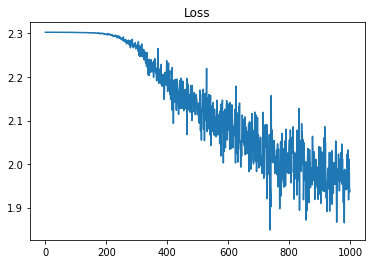

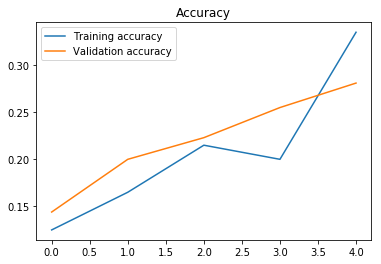

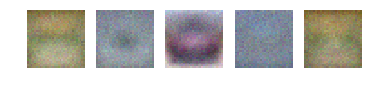

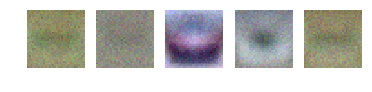

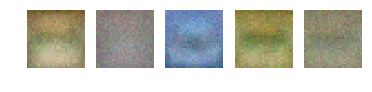

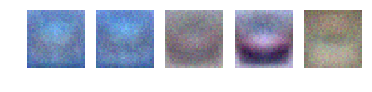

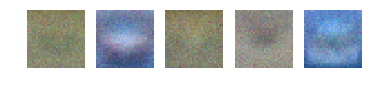

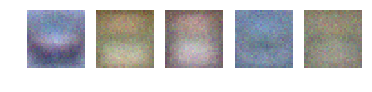

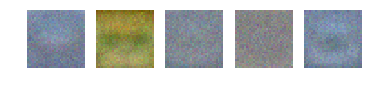

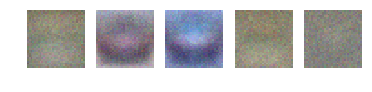

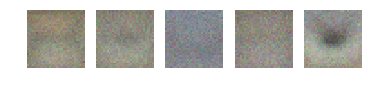

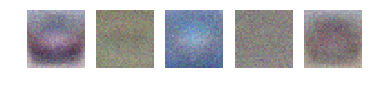

In [5]:
# plot loss curve
show_training_info(optimer)

# show weight image
show_weight_images(model.params[0]['W'], 32)

In [6]:
# check accuracy
scores = model.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The accuracy on testing dataset is ', accuracy)

The accuracy on testing dataset is  0.291


# Run time test

### Backpropagation

In [10]:
# init model
hyperparam = {'reg': 0.25, 'init_scale': 1e-4, 'nums_hidden': [50], 'dropout': 0.5, 'batchnorm': True}

# init model
model1 = get_init_model(hyperparam, device='cpu')
model2 = get_init_model(hyperparam, device='gpu')

# the backpropagation
print('\nRun time for CPU model:')
loss1 = model1.backward(dataloader.x_train[0: 2048, :], dataloader.y_train[0: 2048], print_time=True)

print('\nRun time for GPU model:')
loss2 = model2.backward(dataloader.x_train[0: 2048, :], dataloader.y_train[0: 2048], print_time=True)


Run time for CPU model:

Forward time: 0.06592154502868652
     Linear : 0.05173492431640625
     ReLU : 0.007224082946777344
     DropOut : 0.0014710426330566406
     BatchNorm : 0.0009121894836425781
     Linear : 0.004579305648803711

Backward time: 0.132828950881958
     Linear : 0.0012080669403076172
     BatchNorm : 0.0005807876586914062
     DropOut : 0.001920461654663086
     ReLU : 0.007155418395996094
     Linear : 0.0028235912322998047

Reg time: 0.0007314682006835938

Run time for GPU model:

Forward time: 0.012343883514404297
     Linear : 0.01052999496459961
     ReLU : 0.0006389617919921875
     DropOut : 0.0003299713134765625
     BatchNorm : 0.0006785392761230469
     Linear : 0.00016641616821289062

Backward time: 0.008941650390625
     Linear : 0.0003514289855957031
     BatchNorm : 0.00012421607971191406
     DropOut : 0.0012936592102050781
     ReLU : 0.0003447532653808594
     Linear : 0.005244731903076172

Reg time: 0.0004799365997314453


### Parameters modification

In [9]:
# init optimer
optimer = OptimerAdam({'learn_rate': 1e-3, 'learn_rate_decay':0.95, 'num_iters': 1, 'batch_size': 2048}, 
                      print_every=None)

# parameter modify
print('\nRun time for CPU model:')
optimer.train(model1, dataloader, print_time=True)

print('\nRun time for GPU model:')
optimer.train(model2, dataloader, print_time=True)


Run time for CPU model:
Time: 0.11966323852539062
    Load data: 0.007068634033203125
    Backpropagate: 0.11047220230102539
    Modify parameters: 0.002116680145263672
    Others: 5.7220458984375e-06

Run time for GPU model:
Time: 0.0349879264831543
    Load data: 0.0068666934967041016
    Backpropagate: 0.025517940521240234
    Modify parameters: 0.0026001930236816406
    Others: 3.0994415283203125e-06


# Train multi-layer net

In [14]:
# tune hyperparameters
tuner = ParamTuner(get_model, OptimerSGD, dataloader)
model_best, param_best, acc_best = tuner.tune({'reg': 0.25, 
                                               'nums_hidden': [90],
                                               'init_scale': 1e-4, 
                                               
                                               'learn_rate': 1e-3, 
                                               'learn_rate_decay': 0.95, 
                                               'num_iters': 1400, 
                                               'batch_size': 200}, 
                                              
                                              {'learn_rate': [1e-5, 1e-4, 5e-4, 1e-3, 2e-3],
                                               'nums_hidden': [] + [[i] for i in range(30, 101, 10)], 
                                               'reg': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                                               'num_iters': [i for i in range(200, 2001, 200)]}, epoch=2)

# save model
model_best.save('./saves/MultiLayerNet/model.pkl')

# {'reg': 0.6, 'nums_hidden': [80], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'}

Tune learn_rate in [1e-05, 0.0001, 0.0005, 0.001, 0.002]
With {'reg': 0.25, 'nums_hidden': [90], 'init_scale': 0.0001, 'learn_rate': 1e-05, 'learn_rate_decay': 0.95, 'num_iters': 1400, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.235  - Best!
With {'reg': 0.25, 'nums_hidden': [90], 'init_scale': 0.0001, 'learn_rate': 0.0001, 'learn_rate_decay': 0.95, 'num_iters': 1400, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.327  - Best!
With {'reg': 0.25, 'nums_hidden': [90], 'init_scale': 0.0001, 'learn_rate': 0.0005, 'learn_rate_decay': 0.95, 'num_iters': 1400, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.456  - Best!
With {'reg': 0.25, 'nums_hidden': [90], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 1400, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.493  - Best!
With {'reg': 0.25, 'nums_hidden': [90], 'init_scale': 0.0001, 'learn_rate': 0.002, 'learn_rate_decay': 0.95, 'num_iters': 1400, 'batch_size': 200, 'loss_type

With {'reg': 0.6, 'nums_hidden': [100], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.499
Tune reg in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
With {'reg': 0.2, 'nums_hidden': [80], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.484
With {'reg': 0.3, 'nums_hidden': [80], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.502
With {'reg': 0.4, 'nums_hidden': [80], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.506
With {'reg': 0.5, 'nums_hidden': [80], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'} accuracy: 0.509
With {'reg': 0.6, 'nu

In [15]:
# load model
model = MultiLayerNet.load('./saves/MultiLayerNet/model.pkl')

# check accuracy
scores = model.predict(dataloader.x_test)
accuracy = check_accuracy(scores, dataloader.y_test)
    
print('The best hyperparameter is ', param_best)
print('The best accuracy on validating dataset is ', acc_best)
print('The accuracy on testing dataset is ', accuracy)

The best hyperparameter is  {'reg': 0.6, 'nums_hidden': [80], 'init_scale': 0.0001, 'learn_rate': 0.001, 'learn_rate_decay': 0.95, 'num_iters': 2000, 'batch_size': 200, 'loss_type': 'softmax'}
The best accuracy on validating dataset is  0.514
The accuracy on testing dataset is  0.516


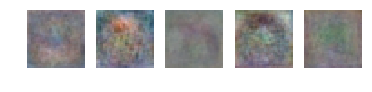

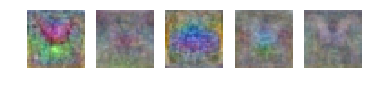

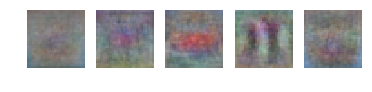

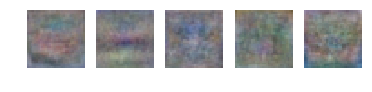

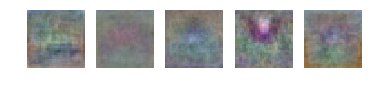

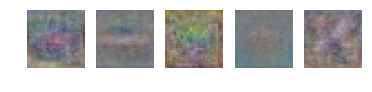

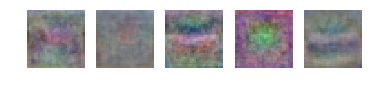

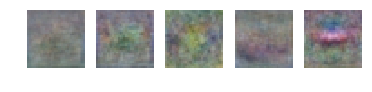

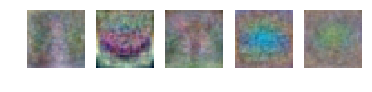

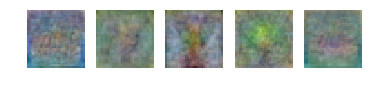

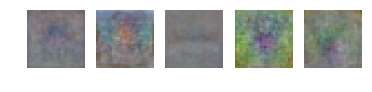

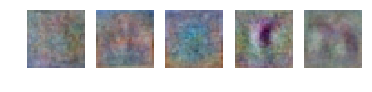

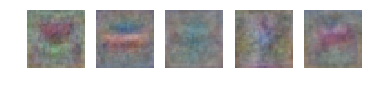

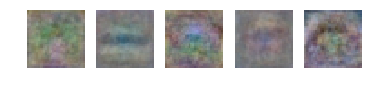

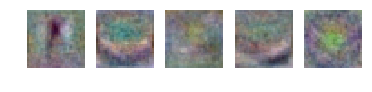

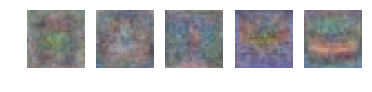

In [16]:
# show weight image
show_weight_images(model_best.params[0]['W'], 32)